In [2]:
%matplotlib inline

import matplotlib.pyplot as plt
import numpy as np

import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import transforms, models

In [3]:
def generate_image(image_size, seed=42):
    input_image = np.random.randn(3, image_size[1], image_size[0])
    scale = np.max([np.max(input_image), -1 * np.min(input_image)])
    input_image = 1 / (16 * scale) * input_image + 0.5
    
    return input_image


def show_array(array, ax):
    ax.imshow(array.transpose(1, 2, 0), vmin=0.0, vmax=1.0);

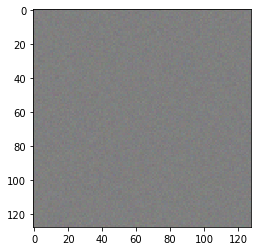

In [4]:
image_size = (128, 128)
input_image = generate_image(image_size)

fig, ax = plt.subplots()
show_array(input_image, ax)

In [5]:
vgg = models.vgg19(pretrained=True).features
for param in vgg.parameters():
    param.requires_grad_(False)
# print(vgg)

In [6]:
def convert_tensor_to_numpy(tensor):
    """ Display a tensor as an image. """
    
    image = tensor.to("cpu").clone().detach()
    image = image.numpy().squeeze()
    image = image.transpose(1,2,0)
    image = image * np.array((0.229, 0.224, 0.225)) + np.array((0.485, 0.456, 0.406))
    image = image.clip(0, 1)

    return image

def show_tensor(tensor, ax):
    array = convert_tensor_to_numpy(tensor)
    ax.imshow(array, vmin=0.0, vmax=1.0)

In [7]:
def get_activation_map_from_layer(image, model, output_layer):
    """ Run an image forward through a model and get the features for 
        a set of layers. Default layers are for VGGNet matching Gatys et al (2016)
    """
    
    layers = {'ReLU1_1' : '1',
              'ReLU2_1' : '6',
              'ReLU3_1' : '11',
              'ReLU4_1' : '20',
              'ReLU5_1' : '29',}

    x = image
    for name, layer in model._modules.items():
        x = layer(x)
        if name == layers[output_layer]:
            return x

In [8]:
def get_normalized_torch_image(array):
    input_torch = torch.Tensor(array).clone()
    normalizer = transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))
    input_torch = normalizer(input_torch).view(1, 3, input_image.shape[1], input_image.shape[2])
    input_torch.requires_grad_(True)

    return input_torch

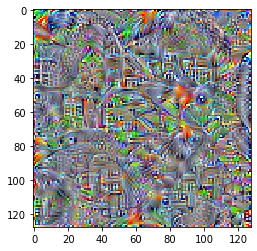

224


In [11]:
device = "cude:0" if torch.cuda.is_available() else "cpu"
vgg = vgg.to(device)

criterion = nn.MSELoss()
steps = 25

# change here to select the filter
list_of_activation_maps = [224]

for i in list_of_activation_maps:
    input_torch = get_normalized_torch_image(input_image)
    input_torch = input_torch.to(device)
    
    optimizer = optim.Adam([input_torch], lr=0.1)

    for ii in range(steps):
        optimizer.zero_grad()

        output = get_activation_map_from_layer(input_torch, vgg, 'ReLU5_1')
        output_channel_i = output[:, i, :, :]
        zero_activation = torch.zeros(output_channel_i.size())
        loss = -1 * criterion(output_channel_i, zero_activation)

        loss.backward()
        optimizer.step()

    else:
        fig, ax = plt.subplots(1, 1)
        show_tensor(input_torch, ax)
        plt.savefig(f"filter_5_1_{i}.png")
        plt.show()
        print(i)